In [119]:
from free_lie_algebra import *
from logsignature import *
import tjl_dense_numpy_tensor
import numpy as np
from esig import tosig
import iisignature
import scipy.sparse as sp
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import pandas as pd
import random
import torch

# Distances

## Example with Sequential MNIST

In [2]:
import pickle

# load streams
with open('input.pickle', 'rb') as handle:
    inputs_MNIST = pickle.load(handle, encoding='latin1')

# load corresponding digit (optional)
with open('output.pickle', 'rb') as handle:
    outputs_MNIST = pickle.load(handle, encoding='latin1')

## Example with pendigits dataset

In [5]:
from urllib.request import urlopen

class Digit:
    def __init__(self, points, digit):
        self.points=points
        self.digit=digit
        
data = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra")

digits=[]
for line in data:
    digitList=line.decode("utf-8").replace(",", " ").replace("\n", "").split()
    number=float(digitList[16])
    points=np.array([[float(digitList[i]), float(digitList[i+1])]
                    for i in range(0,len(digitList)-1, 2)])
    digit=Digit(points, number)
    digits.append(digit)
    
inputs_pendigits = [digit.points/100. for digit in digits]
outputs_pendigits = [int(digit.digit) for digit in digits]

## Signatures

In [6]:
def get_signatures(depth=4, pendigits=True, stop_index = 500):
    
    # calculate signatures of each path
    if pendigits:
        sigs = [signature_of_path_iisignature(x, depth) for x in inputs_pendigits] 
        log_sigs = [bch.getLogSigOfPath(x, depth) for x in inputs_pendigits]
        labels = outputs_pendigits
    else:
        # too many to test distance, so take a random shuffle
        sigs = [signature_of_path_iisignature(x, depth) for x in inputs_MNIST]   
        labels = outputs_MNIST
        data = list(zip(sigs, labels))
        random.shuffle(data)
        sigs, labels = zip(*data[:stop_index])
    
    return sigs, log_sigs, labels

## Testing functions

In [21]:
def test(K, sigs, labels):
    
    # count single digits occurencies
    c = Counter(labels)
    total_digit = [c[i] for i in range(10)]
    final_results = {}
    for k in range(10):
        final_results[k] = np.zeros(10)
    
    for index in range(len(sigs)):
    
        # select element
        element, label = sigs[index], labels[index]

        # calculate distance between selected path signature and all the others in the dataset
        distances = [distance(x, element) for x in sigs]    

        # sort distances and labels in decreasing order
        sorted_index = list(np.argsort(distances))
        data = [(distances[i], labels[i]) for i in sorted_index]
        
        # accuracy measure
        accuracies = np.zeros(10)
        for tup in data[:K]:
            accuracies[tup[1]] += 1
        accuracies /= float(K)
        
        # update final results
        final_results[label] = final_results[label] + accuracies 
    
    return [final_results[k] / float(total_digit[k]) for k in range(10)]

In [24]:
def plot_results(s, K, pendigits=True):
    df = pd.DataFrame(s)
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.heatmap(ax=ax, data=df.values, annot=True, cmap="YlGnBu", fmt = '.5f')
    ax.set_xticklabels(df.columns, rotation=45)
    ax.set_yticklabels(df.index, rotation=45)
    if pendigits:
        title = 'Confusion Matrix for Pendigits dataset with KNN = {}'.format(K)
    else:
        title = 'Confusion Matrix for Sequential MNIST dataset with KNN = {}'.format(K)
    plt.title(title)
    plt.show()

## Results for Pendigits dataset

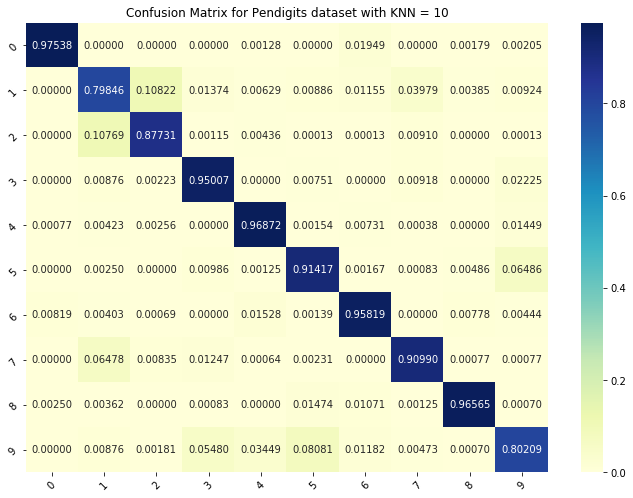

In [295]:
sigs, labels = get_signatures(depth=4)

tes = test(K=10, sigs=sigs, labels=labels)

plot_results(tes, K=10)

## Results for Sequential MNIST dataset

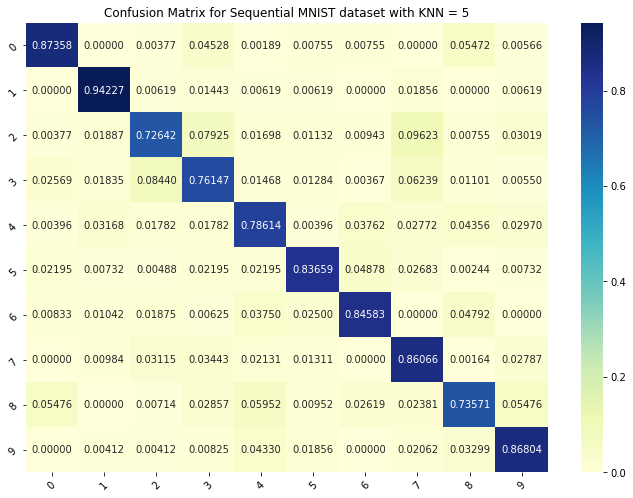

In [26]:
sigs, labels = get_signatures(depth=4, pendigits=False, stop_index=1000)

tes = test(K=5, sigs=sigs, labels=labels)

plot_results(tes, K=5, pendigits=False)

# Experiments

## $$f(S(X)) = log(S(X))$$

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
depth = 3

In [8]:
# let's calculate all signatures of the pendigits dataset
signatures, labels = get_signatures(depth)

# let's fix a basis for the tensor algebra
T = TensorSpaceBasis(word2Elt, None, 2, depth)

# let's extract the numerical coefficients from all signatures and express them as a numpy array
signatures_array = [T.fromElt(elt) for elt in signatures]

# let's compute the target, y = f(S(X)) = log(S(X))
target = [T.fromElt(log(s, maxLevel=depth)) for s in signatures]

### Experiment 1: train with only digit $\alpha$ and try to predict digit $\alpha$

In [9]:
# select a digit from 0 to 9
alpha = 7

# select all corresponding data
data = [(x, y) for x,l,y in zip(signatures_array, labels, target) if l==alpha]

# split train and test
leave_out = 10
data_train, data_test = data[:len(data)-leave_out], data[-leave_out:]

X_train, y_train = np.array([x for (x,y) in data_train]), np.array([y for (x,y) in data_train])
X_test, y_test = np.array([x for (x,y) in data_test]), np.array([y for (x,y) in data_test])

# fit linear functionals
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# compute regression score
print('The R^2 of the prediction is: {}'.format(lin_reg.score(lin_reg.predict(X_test), y_test)))

The R^2 of the prediction is: 1.0


In [271]:
# select a digit from 0 to 9
alpha = 7

# select all corresponding data
data = [(x, y) for x,l,y in zip(signatures, labels, [log(s, maxLevel=depth) for s in signatures]) if l==alpha]

# pi(S(X)) ...linear functional in T(R^width)*
lin_funcs = [pi1(E) for E,_ in data]

# score (MSE)
score = (1./len(data))*np.sum([distance(pi1, y)**2 for (pi1, y) in zip(lin_funcs, [y for _,y in data])])
print('The MS distance between pi1(S(X)) (linear) and log(X) is: {}'.format(score))

The MS distance between pi1(S(X)) (linear) and log(X) is: 4.342174469341482e-32


### Experiment 2: train on digit $\alpha$ and try to predict digit $\beta$

In [10]:
# select 2 digits from 0 to 9
alpha = 1
beta = 5

# select all corresponding training and testing data
data_train = [(x, y) for x,l,y in zip(signatures_array, labels, target) if l==alpha]
data_test = [(x, y) for x,l,y in zip(signatures_array, labels, target) if l==beta]

X_train, y_train = np.array([x for (x,y) in data_train]), np.array([y for (x,y) in data_train])
X_test, y_test = np.array([x for (x,y) in data_test]), np.array([y for (x,y) in data_test])

# fit linear functionals
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# compute regression score
print('The R^2 of the prediction is: {}'.format(lin_reg.score(lin_reg.predict(X_test), y_test)))

The R^2 of the prediction is: 1.0


#### This means that log(S(X)) can be approximated uniformly well by linear functinals on grouplike elements, globally

## $$f(X_t) = max(||X_t||_2^2) - min(||X_t||_2^2) $$

In [3]:
def f(p):
    return np.max(p.T[0]**2 + p.T[1]**2) - np.min(p.T[0]**2 + p.T[1]**2)

In [4]:
depth = 5

In [8]:
# let's calculate all signatures of the pendigits dataset
signatures = [tosig.stream2sig(p, depth) for p in inputs_pendigits] 
labels = outputs_pendigits

# let's compute the target
target = [f(p) for p in inputs_pendigits]

In [57]:
# select a digit from 0 to 9
alpha = 6

# select all corresponding data
data = [(x, y) for x,l,y in zip(signatures, labels, target) if l==alpha]

# split train and test
split = .95
split_index = int(split*len(data))
np.random.shuffle(data)
data_train, data_test = data[:split_index], data[split_index:]

X_train, y_train = np.array([x for (x,y) in data_train]), np.array([y for (x,y) in data_train])
X_test, y_test = np.array([x for (x,y) in data_test]), np.array([y for (x,y) in data_test])

# fit linear functionals
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train.reshape(-1, 1))

# compute regression score
print('For digit {} the MSE of the prediction is: {}'.format(alpha, np.sum((lin_reg.predict(X_test) - y_test.reshape(-1, 1))**2)))

For digit 6 the MSE of the prediction is: 0.14252314441497654


In [54]:
mse = 0

# select a digit from 0 to 9
for alpha in range(10):

    # select all corresponding data
    data = [(x, y) for x,l,y in zip(signatures, labels, target) if l==alpha]

    # split train and test
    split = .95
    split_index = int(split*len(data))
    np.random.shuffle(data)
    data_train, data_test = data[:split_index], data[split_index:]

    X_train, y_train = np.array([x for (x,y) in data_train]), np.array([y for (x,y) in data_train])
    X_test, y_test = np.array([x for (x,y) in data_test]), np.array([y for (x,y) in data_test])

    # fit linear functionals
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train.reshape(-1, 1))

    res = np.sum((lin_reg.predict(X_test) - y_test.reshape(-1, 1))**2)
    
    mse += res
    
    # compute regression score
    print('The MSE of the prediction for the digit {} is: {}'.format(alpha, res))
    
print('The average MSE across all digits is {}'.format(mse/10.))

The MSE of the prediction for the digit 0 is: 0.26599875314396276
The MSE of the prediction for the digit 1 is: 0.9962799622879535
The MSE of the prediction for the digit 2 is: 0.2018330392387352
The MSE of the prediction for the digit 3 is: 0.652271395879714
The MSE of the prediction for the digit 4 is: 0.8381305218631598
The MSE of the prediction for the digit 5 is: 0.10994012299569603
The MSE of the prediction for the digit 6 is: 0.050387150544398955
The MSE of the prediction for the digit 7 is: 0.5210843388535371
The MSE of the prediction for the digit 8 is: 1.7596842354386217
The MSE of the prediction for the digit 9 is: 0.9836488485356953
The average MSE across all digits is 0.6379258368781475


In [55]:
# select 2 digits from 0 to 9
alpha = 3
beta = 5

# select all corresponding training and testing data
data_train = [(x, y) for x,l,y in zip(signatures, labels, target) if l==alpha]
data_test = [(x, y) for x,l,y in zip(signatures, labels, target) if l==beta]

X_train, y_train = np.array([x for (x,y) in data_train]), np.array([y for (x,y) in data_train])
X_test, y_test = np.array([x for (x,y) in data_test]), np.array([y for (x,y) in data_test])

# fit linear functionals
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train.reshape(-1, 1))

# compute regression score
print('The MSE of the prediction is: {}'.format(np.sum((lin_reg.predict(X_test) - y_test.reshape(-1, 1))**2)))

The MSE of the prediction is: 1126304.629554059


#### In this case we see that the accuracy of predictions is high only if done on the same digit as the ones used for training. In other words, we verified Stone-Weierstrass Theorem

## What if we train on all digits and test on all digits?

In [56]:
data = [(x, y) for x,l,y in zip(signatures, labels, target)]

# split train and test
split = .95
split_index = int(split*len(data))
np.random.shuffle(data)
data_train, data_test = data[:split_index], data[split_index:]

X_train, y_train = np.array([x for (x,y) in data_train]), np.array([y for (x,y) in data_train])
X_test, y_test = np.array([x for (x,y) in data_test]), np.array([y for (x,y) in data_test])

# fit linear functionals
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train.reshape(-1, 1))

# compute regression score
print('The MSE of the prediction is: {}'.format(np.sum((lin_reg.predict(X_test) - y_test.reshape(-1, 1))**2)))

The MSE of the prediction is: 12.535882261603042


# Distance

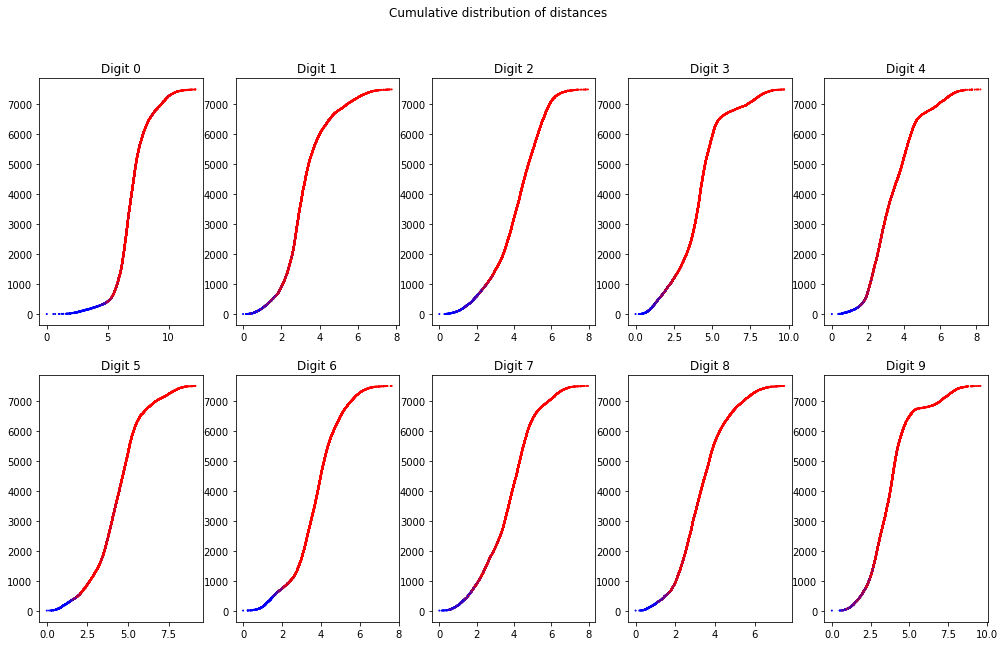

In [85]:
a4_dims = (17, 10)
fig, axes = plt.subplots(2, 5, figsize=a4_dims)
i = 0

depth = 3

# signatures and labels
sigs, labels = get_signatures(depth=depth, pendigits=True)
    
for digit in range(10):

    # select a signature corresponding to selected digit
    index = [i for i,l in zip(range(len(labels)), labels) if l==digit][np.random.randint(100)]
    element = sigs[index]

    # calculate distance between selected path signature and all the others in the dataset
    distances = [distance(x, element) for x in sigs]    

    # sort distances and labels in decreasing order
    sorted_index = list(np.argsort(distances))
    data = [(distances[i], labels[i]) for i in sorted_index]
    
    # plot results
    upper_index = -1
    X = [x for x,_ in data][:upper_index]
    colors = ['blue' if l==digit else 'red' for _,l in data][:upper_index]
    
    if i<5:
        ii = 0
    else:
        ii = 1
    axes[ii, digit % 5].scatter(X, range(len(X)), marker='o', c=colors, s=1)
    axes[ii, digit % 5].set_title('Digit {}'.format(digit))
    i += 1

fig.suptitle('Cumulative distribution of distances')
plt.show()

In [189]:
def inner_product(sig1, sig2, depth, width=2):
    out=0.
    ind1 = 1  
    for k in range(1, depth+1):
        ind2 = width**(k+1)-1
        for x, y in zip(sig1[ind1:ind2], sig2[ind1:ind2]):
            out += x*y
        ind1 = ind2
    return out

def sig_scale(sig, depth, width=2):
#     f = np.vectorize(lambda n,x:x**(n))
    sig_scaled = np.array([1.] + [0.]*(len(sig)-1))
    ind1 = 1
    for k in range(1, depth+1):
        ind2 = width**(k+1)-1
        sig_scaled[ind1:ind2] = sig[ind1:ind2]*math.factorial(k)
        ind1=ind2
    return sig_scaled

def sig_distance1(sig1, sig2, depth):
    d = sig1 - sig2
    return math.sqrt(inner_product(d, d, depth))

def sig_distance2(sig1, sig2, depth):
    d = sig_scale(sig1 - sig2, depth)
    return (inner_product(d, d, depth))**(1./2.)

In [190]:
depth = 5

# signatures and labels
# sigs, _, labels = get_signatures(depth=depth, pendigits=True)
sigs = [tosig.stream2sig(x, depth) for x in inputs_pendigits]
# sigs_scaled = [sig_scale(s, depth) for s in sigs]
# sigs = [signature_of_path_iisignature(x, depth) for x in inputs_pendigits]

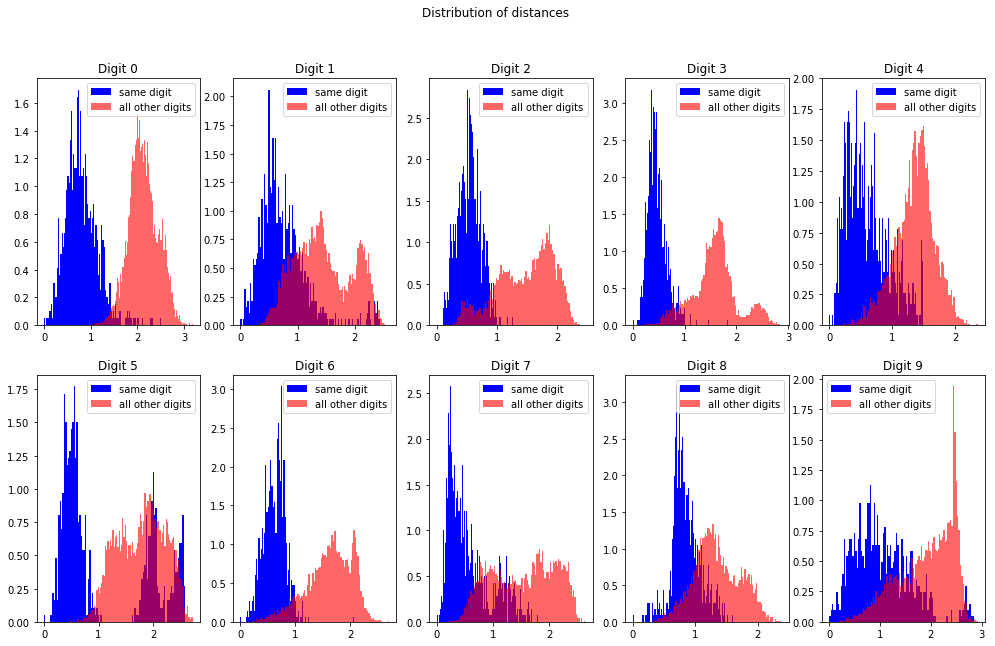

In [192]:
a4_dims = (17, 10)
fig, axes = plt.subplots(2, 5, figsize=a4_dims)
i = 0

for digit in range(10):
    
    # select a signature corresponding to selected digit
    index = [i for i,l in zip(range(len(labels)), labels) if l==digit][np.random.randint(100)]
    element = sigs[index]

    # calculate distance between selected path signature and all the others in the dataset
    distances = [sig_distance(x, element, depth) for x in sigs]
#     distances = [sig_distance(x, element) for x in sigs_scaled]
#     distances = [math.sqrt(np.sum([np.abs(i - j) for i,j in zip(x, element)])) for x in sigs]
#     distances = [sig_distance_modified(element, x) for x in sigs]
    
    data_digit = [d for d,l in zip(distances, labels) if l==digit]
    data_allOthers = [d for d,l in zip(distances, labels) if l!=digit]
    
    if i<5:
        ii = 0
    else:
        ii = 1
    axes[ii, digit % 5].hist(data_digit, 100, density=True, histtype='bar', color='blue', label='same digit')
    axes[ii, digit % 5].hist(data_allOthers, 100, density=True, histtype='bar', color='red', label='all other digits', alpha=0.6)
    axes[ii, digit % 5].legend(prop={'size': 10})
    axes[ii, digit % 5].set_title('Digit {}'.format(digit))
    i += 1

plt.suptitle('Distribution of distances')
plt.show()

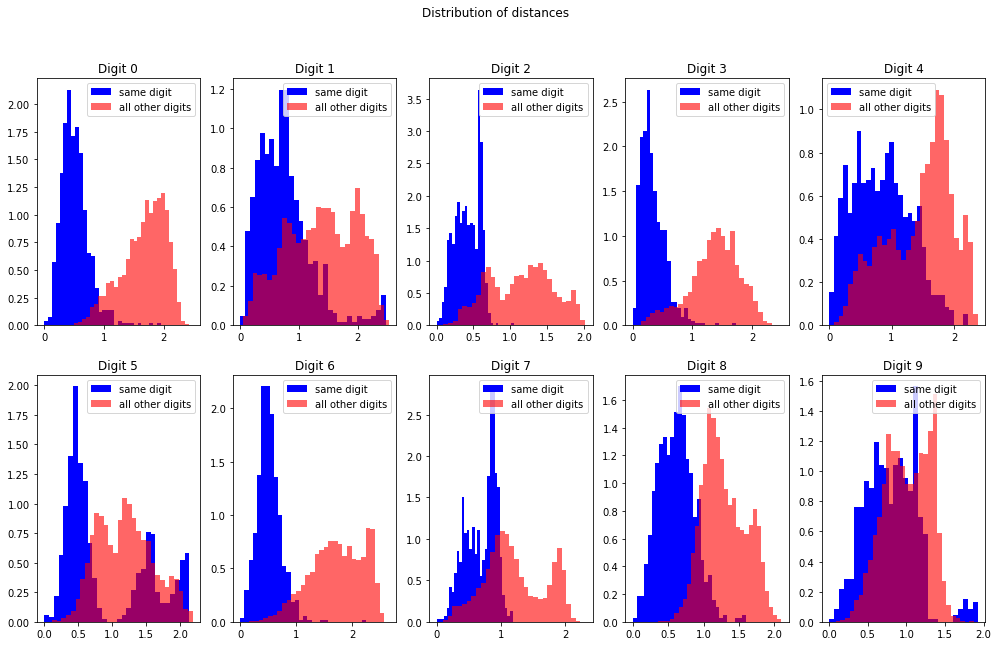

In [166]:
a4_dims = (17, 10)
fig, axes = plt.subplots(2, 5, figsize=a4_dims)
i = 0

for digit in range(10):
    
    # select a signature corresponding to selected digit
    index = [i for i,l in zip(range(len(labels)), labels) if l==digit][np.random.randint(100)]
    element = sigs[index]

    # calculate distance between selected path signature and all the others in the dataset
#     distances = [sig_distance(x, element) for x in sigs]
#     distances = [sig_distance(x, element) for x in sigs_scaled]
#     distances = [math.sqrt(np.sum([np.abs(i - j) for i,j in zip(x, element)])) for x in sigs]
    distances = [distance(element, x) for x in sigs]
    
    data_digit = [d for d,l in zip(distances, labels) if l==digit]
    data_allOthers = [d for d,l in zip(distances, labels) if l!=digit]
    
    if i<5:
        ii = 0
    else:
        ii = 1
    axes[ii, digit % 5].hist(data_digit, 30, density=True, histtype='bar', color='blue', label='same digit')
    axes[ii, digit % 5].hist(data_allOthers, 30, density=True, histtype='bar', color='red', label='all other digits', alpha=0.6)
    axes[ii, digit % 5].legend(prop={'size': 10})
    axes[ii, digit % 5].set_title('Digit {}'.format(digit))
    i += 1

plt.suptitle('Distribution of distances')
plt.show()

# Let's try with Log-signatures

In [100]:
# import numpy as np, numpy, sys, os, scipy.linalg
# from six import print_

# #text, index -> (either number or [res, res]), newIndex
# def parseBracketedExpression(text,index):
#     if(text[index]=='['):
#         left, m = parseBracketedExpression(text,index+1)
#         right, n = parseBracketedExpression(text,m+1)
#         return [left,right],n+1
#     else:
#         n = 0
#         while(n<len(text) and text[index+n] in ['1','2','3','4','5','6','7','8','9']): #this should always just happen once if input is a bracketed expression of letters
#             n = n + 1
#         return int(text[index:index+n]), index+n

# #print (parseBracketedExpression("[23,[2,[[22,1],2]]]",0))

# #bracketed expression, dim -> numpy array of its value, depth
# def multiplyOut(expn, dim):
#     if isinstance(expn,list):
#         left, leftDepth  = multiplyOut(expn[0],dim)
#         right,rightDepth = multiplyOut(expn[1],dim)
#         a = numpy.outer(left,right).flatten()
#         b = numpy.outer(right,left).flatten()
#         return a-b, leftDepth+rightDepth
#     else:
#         a = numpy.zeros(dim)
#         a[expn-1]=1
#         return a,1

# #string of bracketed expression, dim -> numpy array of its value, depth
# #for example:
# #valueOfBracket("[1,2]",2) is ([0,1,-1,0],2)
# def valueOfBracket(text,dim):
#     return multiplyOut(parseBracketedExpression(text,0)[0],dim)

# def getMatrices(s):
#     info=iisignature.info(s)
#     m=info["level"]
#     d=info["dimension"]
#     values=[[] for i in range(m)]
#     for exp in iisignature.basis(s):
#         vec,level = valueOfBracket(exp,d)
#         values[level-1].append(vec)
#     out=[]
#     for v in values:
#         def f(x,y): return numpy.inner(v[x],v[y])
#         out.append(numpy.fromfunction(
#             numpy.vectorize(f),(len(v),len(v)),dtype=int))
# #        store=[]
# #        for x1 in v:
# #            store.append([])
# #            for x2 in v:
# #                store[-1].append(numpy.inner(x1,x2))
# #        out.append(numpy.array(store))
#     return out

In [101]:
# d=2 #width
# m=10 #depth = 3

# # signatures and labels
# s=iisignature.prepare(d,m)
# log_sigs = [iisignature.logsig(i,s) for i in inputs_pendigits]
# matrices=getMatrices(s)   
# adjustment=scipy.linalg.block_diag(*matrices)

In [102]:
# def inner_product_logsignatures(logsig1, logsig2, matrices=matrices, adjustment=adjustment):
#     return float(np.inner(logsig1,np.dot(adjustment,logsig2)))

In [103]:
# def logsig_distance(logsig1, logsig2, matrices=matrices, adjustment=adjustment):
#     logsig_diff = logsig1 - logsig2
#     return math.sqrt(inner_product_logsignatures(logsig_diff, logsig_diff, matrices=matrices, adjustment=adjustment))

In [104]:
# a4_dims = (17, 10)
# fig, axes = plt.subplots(2, 5, figsize=a4_dims)
# i = 0

# for digit in range(10):
    
#     # select a signature corresponding to selected digit
#     index = [i for i,l in zip(range(len(labels)), labels) if l==digit][np.random.randint(100)]
#     element = log_sigs[index]

#     # calculate distance between selected path signature and all the others in the dataset
#     distances = [logsig_distance(x, element) for x in log_sigs]   
    
#     data_digit = [d for d,l in zip(distances, labels) if l==digit]
#     data_allOthers = [d for d,l in zip(distances, labels) if l!=digit]
    
#     if i<5:
#         ii = 0
#     else:
#         ii = 1
#     axes[ii, digit % 5].hist(data_digit, 50, density=True, histtype='bar', color='blue', label='same digit')
#     axes[ii, digit % 5].hist(data_allOthers, 50, density=True, histtype='bar', color='red', label='all other digits', alpha=0.6)
#     axes[ii, digit % 5].legend(prop={'size': 10})
#     axes[ii, digit % 5].set_title('Digit {}'.format(digit))
#     i += 1

# plt.suptitle('Distribution of distances')
# plt.show()

# T-SNE

In [74]:
from sklearn.manifold import TSNE

In [75]:
def plot_mnist(X, y, X_embedded):
    number_of_colors = 10
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(frameon=False)
    plt.title("Two-dimensional embedding of {} handwritten digits from Pendigits Dataset with t-SNE".format(len(sigs)))
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)
    
    r = 0
    for label in np.unique(outputs_pendigits):
        indx = [idx for idx in range(len(y)) if y[idx] == label]
        plt.scatter(X_embedded[indx, 0], X_embedded[indx, 1], c=colors[label], label=label, marker="o")
        
    plt.legend()

In [110]:
X_embedded = TSNE(n_components=2, 
                  perplexity=100, 
                  early_exaggeration=50.,
                  learning_rate = 30.,
                  n_iter=1000,
                  verbose=2, 
                  metric=sig_distance).fit_transform(np.array(sigs))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7494 samples in 0.791s...
[t-SNE] Computed neighbors for 7494 samples in 339.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7494
[t-SNE] Computed conditional probabilities for sample 2000 / 7494
[t-SNE] Computed conditional probabilities for sample 3000 / 7494
[t-SNE] Computed conditional probabilities for sample 4000 / 7494
[t-SNE] Computed conditional probabilities for sample 5000 / 7494
[t-SNE] Computed conditional probabilities for sample 6000 / 7494
[t-SNE] Computed conditional probabilities for sample 7000 / 7494
[t-SNE] Computed conditional probabilities for sample 7494 / 7494
[t-SNE] Mean sigma: 0.244201
[t-SNE] Computed conditional probabilities in 1.011s
[t-SNE] Iteration 50: error = 405.2094421, gradient norm = 0.0000018 (50 iterations in 5.926s)
[t-SNE] Iteration 100: error = 405.2092285, gradient norm = 0.0000662 (50 iterations in 6.560s)
[t-SNE] Iteration 150: error = 404.8339539, gradient no

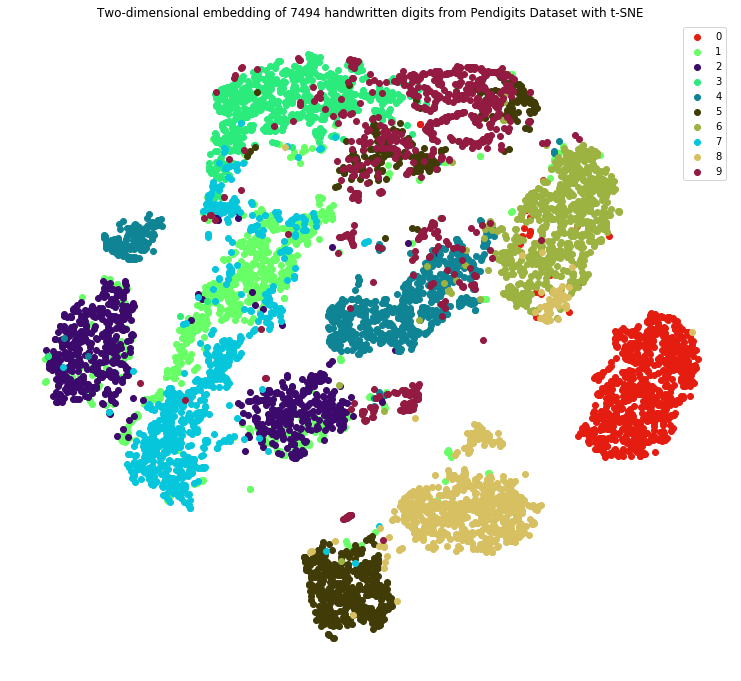

In [111]:
plot_mnist(np.array(log_sigs), outputs_pendigits, X_embedded)